In [1]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import cv2
from skimage.io import imread
from skimage.segmentation import watershed
from shapely.geometry.polygon import LinearRing, Polygon

In [2]:
raw = imread('floor_plans/gmapping_tenbenham_cropped.png')

In [3]:
np.reshape(raw, (raw.shape[0] * raw.shape[1], raw.shape[2])).mean(axis=0)

array([213.6511102 , 213.65124726, 213.6511102 , 255.        ])

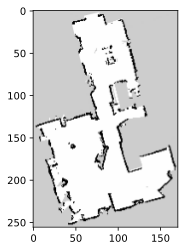

In [4]:
plt.imshow(raw)
plt.show()

In [5]:
bs = 3
markers = np.zeros_like(raw)
for row_idx in range(raw.shape[0] // bs):
    for col_idx in range(raw.shape[1] // bs):
        block = raw[bs * row_idx:bs * row_idx + bs,
                    bs * col_idx:bs * col_idx + bs]
        mean_pixel = block.reshape((bs * bs, 4)).mean(axis=0)
        if np.all(mean_pixel >= [220, 220, 220, 255]):
            markers[bs * row_idx:bs * row_idx + bs,
                    bs * col_idx:bs * col_idx + bs] = 255

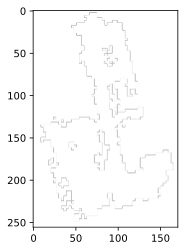

In [6]:
plt.imshow(markers)
plt.show()

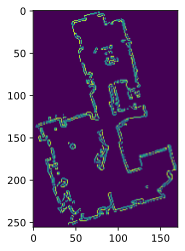

In [7]:
gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize = 3)
plt.imshow(edges)
plt.show()

In [8]:
edges.shape

(256, 171)

In [9]:
# copied directly from 
# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_houghlines/py_houghlines.html
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 20, 10)
lines = lines.reshape(lines.shape[1], lines.shape[0], lines.shape[2])
print(lines.shape)
for x1, y1, x2, y2 in lines[0]:
    pass
    #cv2.line(raw, (x1,y1), (x2,y2), (0,255,0), 2)

(1, 420, 4)


In [10]:
cv2.imwrite('houghlines5.jpg',raw)

True

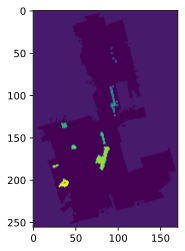

In [11]:
# https://stackoverflow.com/questions/35189322/opencv-polygon-detection-methods
th, im_th = cv2.threshold(gray, 220, 250, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
im_th2 = cv2.morphologyEx(im_th, cv2.MORPH_OPEN, kernel)
# Connected Components segmentation:
maxLabels, labels = cv2.connectedComponents(im_th2)
plt.imshow(labels)

In [12]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([17068, 26187,    10,     6,     6,     6,     4,    98,     4,
           35,    39,    25,   199,    18,    71]))

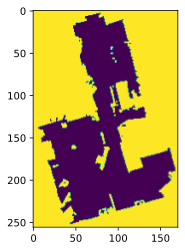

In [13]:
plt.imshow(im_th2)

In [14]:
labels.shape

(256, 171)

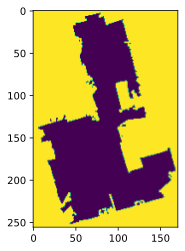

In [15]:
room_outline = np.zeros_like(labels, dtype=np.uint8)
room_outline[labels == 1] = 1
plt.imshow(room_outline)
plt.show()

In [16]:
contours, _ = cv2.findContours(room_outline,
                                 cv2.RETR_TREE,
                                 cv2.CHAIN_APPROX_SIMPLE)

737 50


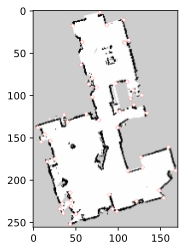

In [17]:
base = raw.copy()
poly = cv2.approxPolyDP(contours[15], 5, True)
print(len(contours[15]), len(poly))
plt.imshow(cv2.drawContours(base, poly, -1, (255, 0, 0), 4))
plt.show()

In [18]:
p = poly.reshape(poly.shape[0], poly.shape[2])
p = np.append(p, [p[0]], axis=0)

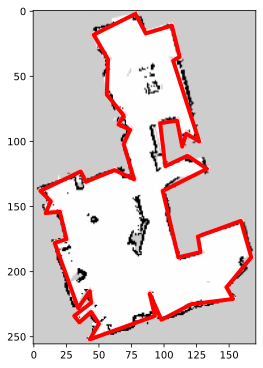

In [19]:
fig, ax = plt.subplots(figsize=(4, 8))
ax.imshow(base)
ax.plot(p[:, 0], p[:, 1], color='red', linewidth=4)
plt.show()

In [20]:
gdf = gpd.GeoDataFrame({
    'name': ['tenbenham'],
    'type': ['room'],
    'geometry': [Polygon(p)]
})
gdf.to_file('tenbenham.geojson', driver='GeoJSON')